In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import warnings
import lightgbm as lgb
import matplotlib.pyplot as plt
import time

from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score,roc_auc_score,accuracy_score,roc_curve, plot_roc_curve

import imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN 
 
warnings.filterwarnings('ignore')

start = time.time()

In [12]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
       

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
application = pd.read_csv('appIication_train.csv')
data = reduce_mem_usage(application)

Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


In [14]:
data.shape

(307511, 122)

In [15]:
def split_train(data,test_ratio):
   #  data = data.iloc[0:20000,:]
    shuffled_indices=np.random.permutation(len(data))
    test_set_size=int(len(data)*test_ratio)
    test_indices =shuffled_indices[:test_set_size]
    train_indices=shuffled_indices[test_set_size:]
    return data.iloc[train_indices],data.iloc[test_indices]

In [16]:
train_app, test_app = split_train(data, 0.2)
print(train_app.shape)
print(test_app.shape)
all_data_x = data.drop(['TARGET','SK_ID_CURR'],axis = 1)
all_data_y = data.loc[:,['TARGET']].values

train_app_x = train_app.drop(['TARGET','SK_ID_CURR'],axis = 1)
train_app_y = train_app.loc[:,['TARGET']].values

test_app_x = test_app.drop(['TARGET','SK_ID_CURR'],axis = 1)
test_app_y = test_app['TARGET'].values

(246009, 122)
(61502, 122)


In [17]:
types = np.array([z for z in all_data_x.dtypes])
all_columns = all_data_x.columns.values                
is_num = types != 'object'  
# is_num = np.array([str(x)[:1] != 'c' for x in types]) 
num_features = all_columns[is_num].tolist()         
cat_features = all_columns[~is_num].tolist() 
features = num_features + cat_features
Pipe_num = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy = 'mean')),        # tried median, mean, constant strategies
    ('scaler', StandardScaler()) ])

Pipe_cat = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'Unknown')),
    ('onehot', OneHotEncoder())        ])

preprocessor = ColumnTransformer(
    transformers = [
        ('num', Pipe_num, num_features),
        ('cat', Pipe_cat, cat_features)])
    
preprocessor.fit(data[features])

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                                  'AMT_CREDIT', 'AMT_ANNUITY',
                                  'AMT_GOODS_PRICE',
                                  'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                  'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                                  'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
                                  'FLAG_MOBIL', 'FLAG_EMP_PHONE',
                                  'FLAG_WORK_PHONE'...
                                                                strategy='constant')),
                                                 ('onehot', OneHotEncoder())]),
                                 ['NAME_CONTRACT_TYPE', 'CODE_GENDER',
                                  'FL

In [8]:
def model_process(X_train, y_train,X_test,y_test):
    
    # LR
    LR = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True, max_iter=500, multi_class='auto',
                            random_state=42, solver='sag',n_jobs=-1)
    
    # GaussianNB
    gnb = GaussianNB()
    
    # DNN
    dnn = MLPClassifier(hidden_layer_sizes=(400,),activation='relu',max_iter=300, alpha=0.01,learning_rate_init = 0.01, learning_rate= 'constant')
    
    # 决策树
    clf=DecisionTreeClassifier(random_state=0)
    
    # 随机森林
    rfc=RandomForestClassifier(n_estimators=100)
      
    # 集成学习 adaBoost
    ada = AdaBoostClassifier(n_estimators=100, random_state=0)
    
    # gbm
    gbm = lgb.LGBMClassifier()
    
    # LR
    print("=============================逻辑回归================================")
    print("训练开始")
    LR = LR.fit(X_train,y_train)
    print("训练结束")
    y_pred = LR.predict(X_test)

    print("训练集精确度:{%.3f}    "%LR.score(X_train, y_train), "测试集精确度:{%.3f}    \n"%LR.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, LR.predict_proba(X_train)[:,1]), 
          "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, LR.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,LR.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("LR 的KS:{%.4f}"%ks)
#     print("=================================================================")
    
    
    # GaussianNB
    print("=============================GaussianNB================================")
    print("训练开始")
    gnb = gnb.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = gnb.predict(X_test)

    print("训练集精确度:{%.3f}    "%gnb.score(X_train, y_train), 
        "测试集精确度:{%.3f}    \n"%gnb.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, gnb.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, gnb.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,gnb.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("GaussianNB 的KS:{%.4f}"%ks)
    print("=================================================================")
    

     # DNN
    print("=============================DNN================================")
    print("训练开始")
    dnn = dnn.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = dnn.predict(X_test)

    print("训练集精确度:{%.4f}    "%dnn.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%dnn.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, dnn.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, dnn.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    
    fpr,tpr,thresholds = roc_curve(y_test,dnn.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("dnn 的KS:{%.4f}"%ks)
    print("=================================================================")
    
     # Decision Tree
    print("=============================Decision Tree================================")
    print("训练开始")
    clf = clf.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = clf.predict(X_test)

    print("训练集精确度:{%.4f}    "%clf.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%clf.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,clf.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("dt 的KS:{%.4f}"%ks)
    print("=================================================================")
    
    
     # Random Forest
    print("=============================Random Forest================================")
    print("训练开始")
    rfc = rfc.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = rfc.predict(X_test)

    print("训练集精确度:{%.4f}    "%rfc.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%rfc.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, rfc.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,rfc.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("rf 的KS:{%.4f}"%ks)
#     print("=================================================================")
    
    
    # AdaBoost
    print("=============================AdaBoost================================")
    print("训练开始")
    ada = ada.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = ada.predict(X_test)

    print("训练集精确度:{%.4f}    "%ada.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%ada.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, ada.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, ada.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,ada.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("ada 的KS:{%.4f}"%ks)
    print("=================================================================")
    
    
    # gbm
    print("=============================GBM================================")
    print("训练开始")
    gbm = gbm.fit(X_train,y_train.ravel())
    print("训练结束")
    y_pred = gbm.predict(X_test)

    print("训练集精确度:{%.4f}    "%gbm.score(X_train, y_train), 
        "测试集精确度:{%.4f}    \n"%gbm.score(X_test, y_test))
    #print("predict 训练集auc:{%.3f} "%metrics.roc_auc_score(y_train, clf.predict(X_train)), "训练集auc:{%.3f}\n"%metrics.roc_auc_score(y_test, clf.predict(X_test)))
    print("predict_proba 训练集auc:{%.4f} "%metrics.roc_auc_score(y_train, gbm.predict_proba(X_train)[:,1]), 
                        "训练集auc:{%.4f}\n"%metrics.roc_auc_score(y_test, gbm.predict_proba(X_test)[:,1]))

    print("classification_report:")
    print(metrics.classification_report(y_test, y_pred))
    
    fpr,tpr,thresholds = roc_curve(y_test,gbm.predict_proba(X_test)[:,1])
    ks = max(tpr-fpr)
    print("gbm 的KS:{%.4f}"%ks)
    print("=================================================================")
    return LR, gnb,dnn, clf, rfc,ada,gbm
    

# 原数据

In [9]:
X_train = preprocessor.transform(train_app_x[features])
y_train = train_app_y
X_test = preprocessor.transform(test_app_x[features])
y_test = test_app_y
print(X_train.shape)

(246009, 250)


In [10]:
LR, gnb,dnn, clf, rfc,ada,gbm = model_process(X_train, y_train,X_test,y_test)

=============================逻辑回归================================
训练开始
训练结束
训练集精确度:{0.920}     测试集精确度:{0.918}    

predict_proba 训练集auc:{0.712}  训练集auc:{0.704}

classification_report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56472
           1       0.64      0.00      0.00      5030

    accuracy                           0.92     61502
   macro avg       0.78      0.50      0.48     61502
weighted avg       0.90      0.92      0.88     61502

LR 的KS:{0.3037}
=============================GaussianNB================================
训练开始
训练结束
训练集精确度:{0.133}     测试集精确度:{0.133}    

predict_proba 训练集auc:{0.528}  训练集auc:{0.522}

classification_report:
              precision    recall  f1-score   support

           0       0.95      0.06      0.11     56472
           1       0.08      0.97      0.15      5030

    accuracy                           0.13     61502
   macro avg       0.52      0.51      0.13     61502
weighted av

<Figure size 1296x576 with 0 Axes>

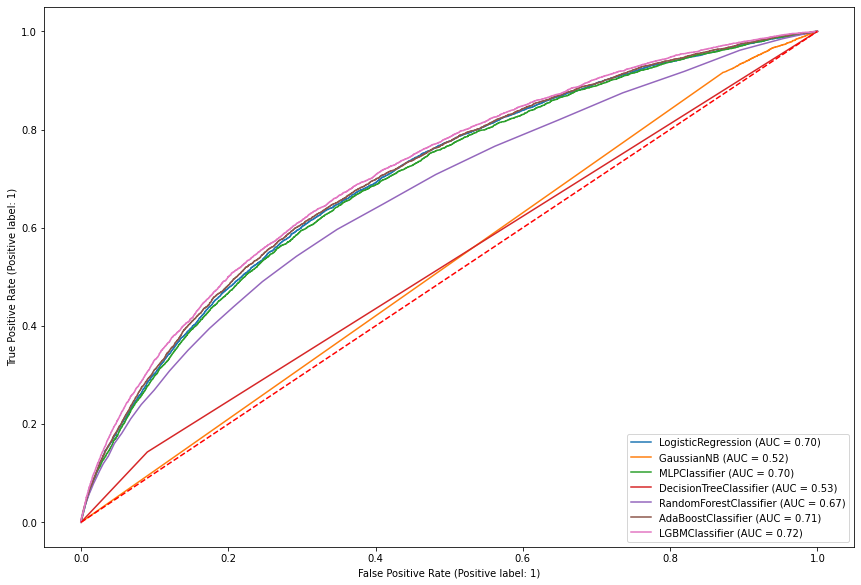

In [15]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots()
LR_disp = plot_roc_curve(LR, X_test, y_test,ax = ax)
gnb_disp = plot_roc_curve(gnb, X_test, y_test,ax = ax)
dnn_disp = plot_roc_curve(dnn, X_test, y_test,ax = ax)
clf_disp = plot_roc_curve(clf, X_test, y_test,ax = ax)
rfc_disp = plot_roc_curve(rfc, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(ada, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(gbm, X_test, y_test,ax= ax)

ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust( right=2, top = 2)
# LR_disp.figure_.suptitle("ROC curve comparison")
# ax.set_title("ROC curve comparison")
plt.show()

# 随机下采样

count_class_0: 226214
count_class_1: 19795
Random under-sampling:
0    19795
1    19795
Name: TARGET, dtype: int64


<AxesSubplot:title={'center':'Count (TARGET)'}>

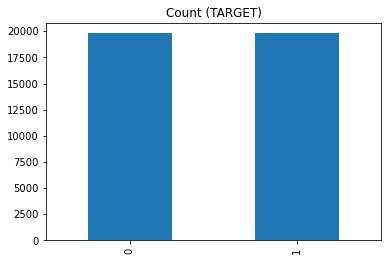

In [16]:
# Class count
count_class_0, count_class_1 = train_app.TARGET.value_counts()
print('count_class_0:',count_class_0)
print('count_class_1:',count_class_1)

# Divide by class 分开样本
df_class_0 = train_app[train_app['TARGET'] == 0]
df_class_1 = train_app[train_app['TARGET'] == 1]

# 下采样，采样个数为count_class_1: 24825
df_class_0_under = df_class_0.sample(count_class_1)
# 采样过后，进行合并
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)
print('Random under-sampling:')
print(df_test_under.TARGET.value_counts())
df_test_under.TARGET.value_counts().plot(kind='bar', title='Count (TARGET)')

In [17]:
X_train = df_test_under.drop(['TARGET', 'SK_ID_CURR'], axis = 1)
X_train = preprocessor.transform(X_train[features])
y_train = df_test_under['TARGET'].values
X_test = preprocessor.transform(test_app_x[features])
y_test = test_app_y

In [20]:
test = y_train.reshape(y_train.shape[0],)

print('Original dataset shape %s' % Counter(test))

Original dataset shape Counter({0: 19795, 1: 19795})


In [21]:
LR, gnb,dnn, clf, rfc,ada,gbm = model_process(X_train, y_train,X_test,y_test)

=============================逻辑回归================================
训练开始
训练结束
训练集精确度:{0.658}     测试集精确度:{0.659}    

predict_proba 训练集auc:{0.715}  训练集auc:{0.702}

classification_report:
              precision    recall  f1-score   support

           0       0.95      0.66      0.78     56472
           1       0.14      0.64      0.23      5030

    accuracy                           0.66     61502
   macro avg       0.55      0.65      0.51     61502
weighted avg       0.89      0.66      0.74     61502

LR 的KS:{0.3031}
=============================GaussianNB================================
训练开始
训练结束
训练集精确度:{0.587}     测试集精确度:{0.471}    

predict_proba 训练集auc:{0.627}  训练集auc:{0.600}

classification_report:
              precision    recall  f1-score   support

           0       0.94      0.45      0.61     56472
           1       0.10      0.69      0.18      5030

    accuracy                           0.47     61502
   macro avg       0.52      0.57      0.39     61502
weighted av

<Figure size 1296x576 with 0 Axes>

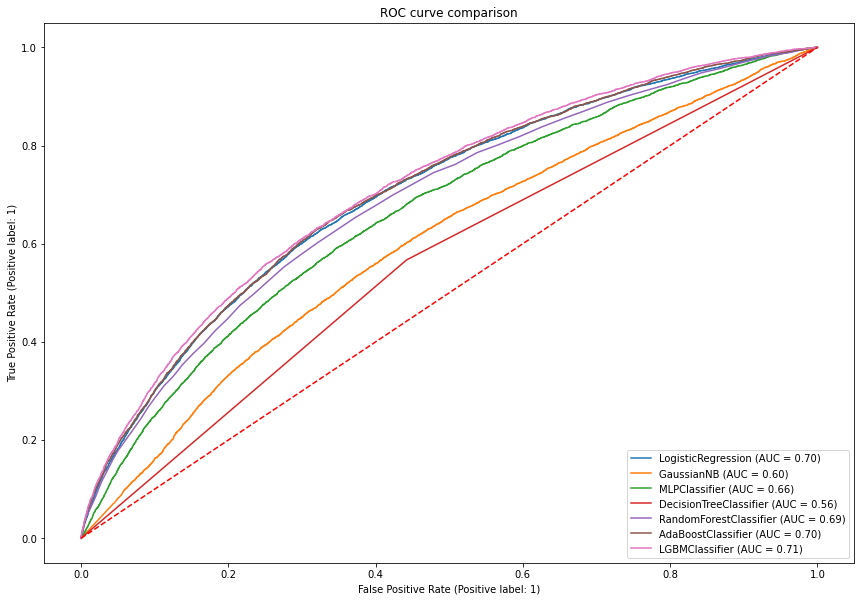

In [23]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots()
LR_disp = plot_roc_curve(LR, X_test, y_test,ax = ax)
gnb_disp = plot_roc_curve(gnb, X_test, y_test,ax = ax)
dnn_disp = plot_roc_curve(dnn, X_test, y_test,ax = ax)
clf_disp = plot_roc_curve(clf, X_test, y_test,ax = ax)
rfc_disp = plot_roc_curve(rfc, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(ada, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(gbm, X_test, y_test,ax= ax)

ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust( right=2, top = 2)
# LR_disp.figure_.suptitle("ROC curve comparison")
ax.set_title("ROC curve comparison")
plt.show()

# 下采样：Tomek links

In [24]:
X_train = preprocessor.transform(train_app_x[features])
y_train = train_app_y
X_test = preprocessor.transform(test_app_x[features])
y_test = test_app_y

tl = TomekLinks(sampling_strategy='auto', n_jobs = -1)
tl.fit(X_train, y_train)

TomekLinks(n_jobs=-1)

In [25]:
train_tl = train_app.iloc[0:20000, :]
train_tl_x = train_tl.drop(['TARGET','SK_ID_CURR'],axis = 1)
train_tl_y = train_tl.loc[:,['TARGET']].values
X_train_tl = preprocessor.transform(train_tl_x[features])
y_train_tl = train_tl_y

In [26]:
X_tl, y_tl = tl.fit_resample(X_train_tl, y_train_tl)
test = y_tl.reshape(y_tl.shape[0],)

print('Tomek links dataset shape %s' % Counter(test))

Tomek links dataset shape Counter({0: 17951, 1: 1617})


In [27]:
LR, gnb,dnn, clf, rfc,ada,gbm = model_process(X_tl, y_tl, X_test, y_test)

=============================逻辑回归================================
训练开始
训练结束
训练集精确度:{0.917}     测试集精确度:{0.921}    

predict_proba 训练集auc:{0.731}  训练集auc:{0.697}

classification_report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56649
           1       0.34      0.00      0.01      4853

    accuracy                           0.92     61502
   macro avg       0.63      0.50      0.48     61502
weighted avg       0.88      0.92      0.88     61502

LR 的KS:{0.2971}
=============================GaussianNB================================
训练开始
训练结束
训练集精确度:{0.128}     测试集精确度:{0.125}    

predict_proba 训练集auc:{0.523}  训练集auc:{0.511}

classification_report:
              precision    recall  f1-score   support

           0       0.94      0.05      0.10     56649
           1       0.08      0.96      0.15      4853

    accuracy                           0.12     61502
   macro avg       0.51      0.51      0.12     61502
weighted av

<Figure size 1296x576 with 0 Axes>

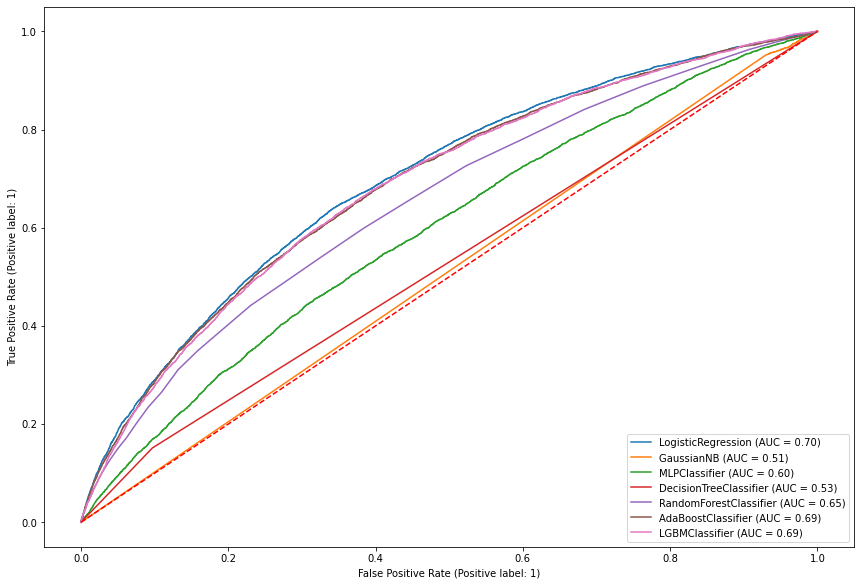

In [28]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots()
LR_disp = plot_roc_curve(LR, X_test, y_test,ax = ax)
gnb_disp = plot_roc_curve(gnb, X_test, y_test,ax = ax)
dnn_disp = plot_roc_curve(dnn, X_test, y_test,ax = ax)
clf_disp = plot_roc_curve(clf, X_test, y_test,ax = ax)
rfc_disp = plot_roc_curve(rfc, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(ada, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(gbm, X_test, y_test,ax= ax)

ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust( right=2, top = 2)
# LR_disp.figure_.suptitle("ROC curve comparison")
# ax.set_title("ROC curve comparison")
plt.show()

# CondensedNearestNeighbour: 下采样。效率低速度慢，不适合高维数据。

基于压缩最近邻方法的欠采样。

1. 得到一个集合C中的所有少数样本。
2. 在C中添加一个来自目标类(待欠采样类)的样本，并在集合S中添加该类的所有其他样本。
3. 遍历集合S，一个样本一个样本，使用1个最近邻规则对每个样本进行分类。
4. 如果样本分类错误，则将其添加到C中，否则不做任何操作。
5. 在S上反复，直到没有样品需要添加。

In [30]:
from imblearn.under_sampling import CondensedNearestNeighbour 

X_train = preprocessor.transform(train_app_x[features])
y_train = train_app_y
X_test = preprocessor.transform(test_app_x[features])
y_test = test_app_y

cnn = CondensedNearestNeighbour(random_state=42, n_jobs = -1)
cnn.fit(X_train, y_train)

train_cnn = train_app.iloc[0:2000, :]
train_cnn_x = train_cnn.drop(['TARGET','SK_ID_CURR'],axis = 1)
train_cnn_y = train_cnn.loc[:,['TARGET']].values
X_train_cnn = preprocessor.transform(train_cnn_x[features])
y_train_cnn = train_cnn_y

X_cnn, y_cnn = cnn.fit_resample(X_train_cnn, y_train_cnn)
test = y_cnn.reshape(y_cnn.shape[0],)

print('Tomek links dataset shape %s' % Counter(test))

Tomek links dataset shape Counter({0: 466, 1: 147})


In [31]:
LR, gnb,dnn, clf, rfc,ada,gbm = model_process(X_cnn, y_cnn, X_test, y_test)

=============================逻辑回归================================
训练开始
训练结束
训练集精确度:{0.773}     测试集精确度:{0.907}    

predict_proba 训练集auc:{0.715}  训练集auc:{0.658}

classification_report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     56501
           1       0.21      0.05      0.08      5001

    accuracy                           0.91     61502
   macro avg       0.56      0.52      0.52     61502
weighted avg       0.86      0.91      0.88     61502

LR 的KS:{0.2344}
=============================GaussianNB================================
训练开始
训练结束
训练集精确度:{0.380}     测试集精确度:{0.209}    

predict_proba 训练集auc:{0.592}  训练集auc:{0.505}

classification_report:
              precision    recall  f1-score   support

           0       0.92      0.15      0.26     56501
           1       0.08      0.86      0.15      5001

    accuracy                           0.21     61502
   macro avg       0.50      0.50      0.20     61502
weighted av

<Figure size 1296x576 with 0 Axes>

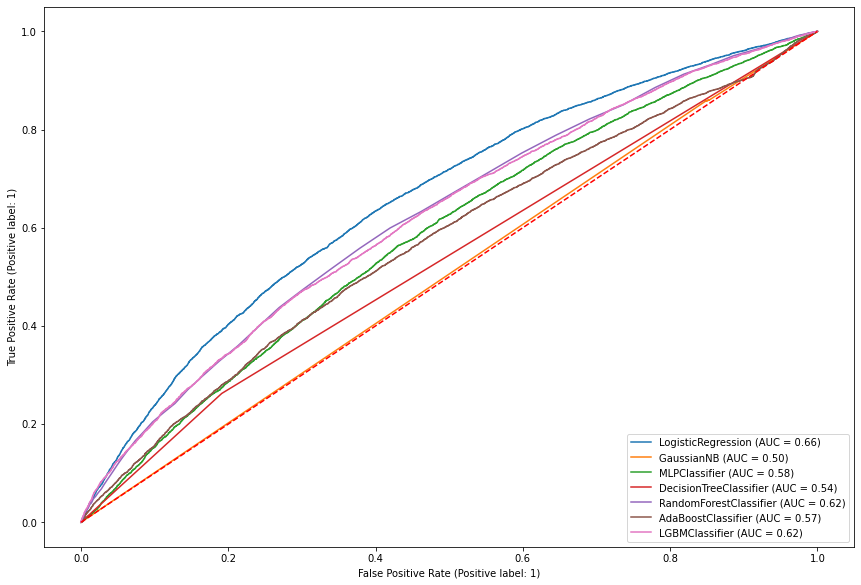

In [32]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots()
LR_disp = plot_roc_curve(LR, X_test, y_test,ax = ax)
gnb_disp = plot_roc_curve(gnb, X_test, y_test,ax = ax)
dnn_disp = plot_roc_curve(dnn, X_test, y_test,ax = ax)
clf_disp = plot_roc_curve(clf, X_test, y_test,ax = ax)
rfc_disp = plot_roc_curve(rfc, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(ada, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(gbm, X_test, y_test,ax= ax)

ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust( right=2, top = 2)
# LR_disp.figure_.suptitle("ROC curve comparison")
# ax.set_title("ROC curve comparison")
plt.show()

# EditedNearestNeighbours
基于编辑最近邻法的欠采样。
该方法将通过删除接近决策边界的样本来清理数据库。

In [14]:
from imblearn.under_sampling import EditedNearestNeighbours 

X_train = preprocessor.transform(train_app_x[features])
y_train = train_app_y
X_test = preprocessor.transform(test_app_x[features])
y_test = test_app_y

enn = EditedNearestNeighbours(n_neighbors=5, n_jobs = -1)
enn.fit(X_train, y_train)

train_enn = train_app.iloc[0:20000, :]
train_enn_x = train_enn.drop(['TARGET','SK_ID_CURR'],axis = 1)
train_enn_y = train_enn.loc[:,['TARGET']].values
X_train_enn = preprocessor.transform(train_enn_x[features])
y_train_enn = train_enn_y

X_enn, y_enn = enn.fit_resample(X_train_enn, y_train_enn)
test = y_enn.reshape(y_enn.shape[0],)

print('Tomek links dataset shape %s' % Counter(test))

Tomek links dataset shape Counter({0: 12618, 1: 1568})


In [15]:
LR, gnb,dnn, clf, rfc,ada,gbm = model_process(X_enn, y_enn, X_test, y_test)

=============================逻辑回归================================
训练开始
训练结束
训练集精确度:{0.893}     测试集精确度:{0.909}    

predict_proba 训练集auc:{0.773}  训练集auc:{0.693}

classification_report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     56456
           1       0.28      0.07      0.11      5046

    accuracy                           0.91     61502
   macro avg       0.60      0.53      0.53     61502
weighted avg       0.87      0.91      0.88     61502

LR 的KS:{0.2828}
=============================GaussianNB================================
训练开始
训练结束
训练集精确度:{0.203}     测试集精确度:{0.167}    

predict_proba 训练集auc:{0.548}  训练集auc:{0.527}

classification_report:
              precision    recall  f1-score   support

           0       0.94      0.10      0.18     56456
           1       0.08      0.93      0.16      5046

    accuracy                           0.17     61502
   macro avg       0.51      0.52      0.17     61502
weighted av

<Figure size 1296x576 with 0 Axes>

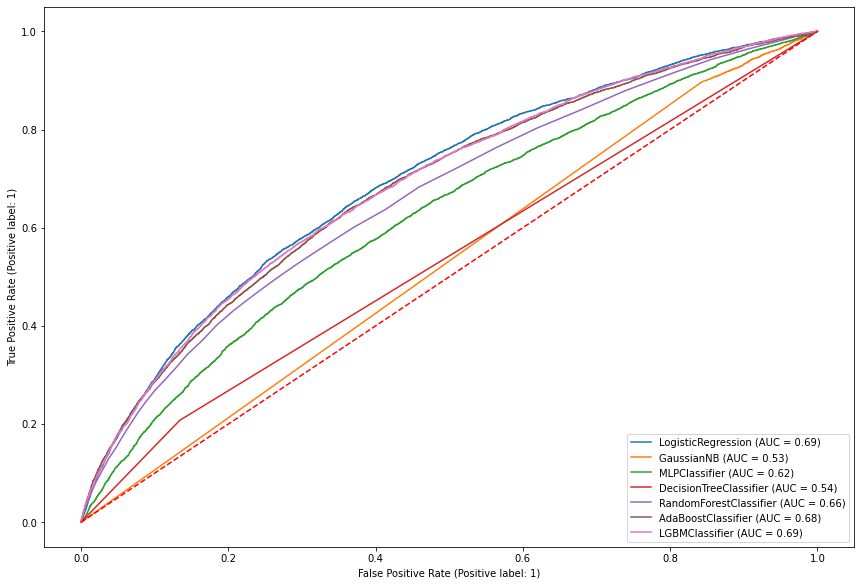

In [16]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots()
LR_disp = plot_roc_curve(LR, X_test, y_test,ax = ax)
gnb_disp = plot_roc_curve(gnb, X_test, y_test,ax = ax)
dnn_disp = plot_roc_curve(dnn, X_test, y_test,ax = ax)
clf_disp = plot_roc_curve(clf, X_test, y_test,ax = ax)
rfc_disp = plot_roc_curve(rfc, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(ada, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(gbm, X_test, y_test,ax= ax)

ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust( right=2, top = 2)
# LR_disp.figure_.suptitle("ROC curve comparison")
# ax.set_title("ROC curve comparison")
plt.show()

# 随机过采样

In [33]:
X_train = preprocessor.transform(train_app_x[features])
y_train = train_app_y
X_test = preprocessor.transform(test_app_x[features])
y_test = test_app_y

ros = RandomOverSampler(random_state=42)
ros.fit(X_train, y_train)

RandomOverSampler(random_state=42)

In [34]:
test = y_train.reshape(y_train.shape[0],)

print('Original dataset shape %s' % Counter(test))

X_train, y_train = ros.fit_resample(X_train, y_train)

test = y_train.reshape(y_train.shape[0],)

print('Over-resample dataset shape %s' % Counter(test))

Original dataset shape Counter({0: 226185, 1: 19824})
Over-resample dataset shape Counter({0: 226185, 1: 226185})


In [35]:
LR, gnb,dnn, clf, rfc,ada,gbm = model_process(X_train, y_train, X_test, y_test)

=============================逻辑回归================================
训练开始
训练结束
训练集精确度:{0.656}     测试集精确度:{0.668}    

predict_proba 训练集auc:{0.713}  训练集auc:{0.710}

classification_report:
              precision    recall  f1-score   support

           0       0.95      0.67      0.79     56501
           1       0.15      0.64      0.24      5001

    accuracy                           0.67     61502
   macro avg       0.55      0.65      0.51     61502
weighted avg       0.89      0.67      0.74     61502

LR 的KS:{0.3102}
=============================GaussianNB================================
训练开始
训练结束
训练集精确度:{0.515}     测试集精确度:{0.136}    

predict_proba 训练集auc:{0.531}  训练集auc:{0.530}

classification_report:
              precision    recall  f1-score   support

           0       0.95      0.06      0.12     56501
           1       0.08      0.96      0.15      5001

    accuracy                           0.14     61502
   macro avg       0.52      0.51      0.14     61502
weighted av

<Figure size 1296x576 with 0 Axes>

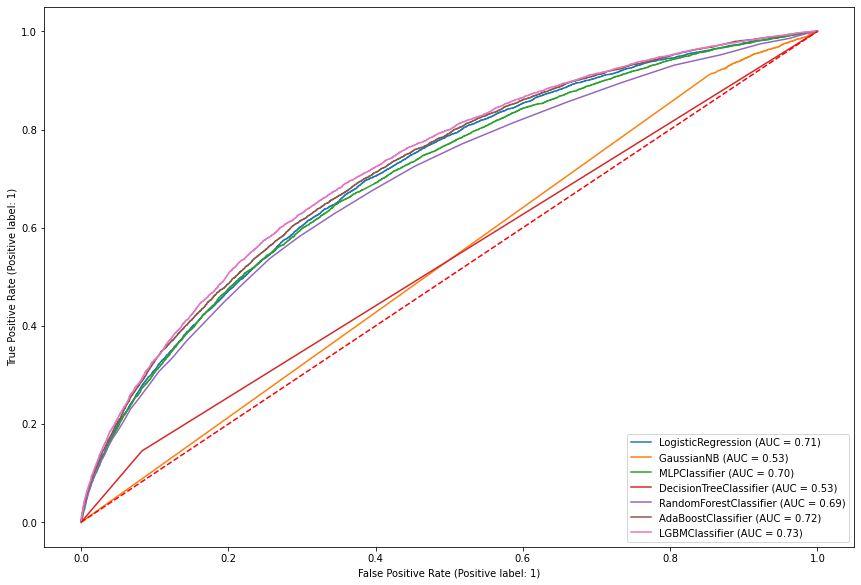

In [36]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots()
LR_disp = plot_roc_curve(LR, X_test, y_test,ax = ax)
gnb_disp = plot_roc_curve(gnb, X_test, y_test,ax = ax)
dnn_disp = plot_roc_curve(dnn, X_test, y_test,ax = ax)
clf_disp = plot_roc_curve(clf, X_test, y_test,ax = ax)
rfc_disp = plot_roc_curve(rfc, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(ada, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(gbm, X_test, y_test,ax= ax)

ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust( right=2, top = 2)
# LR_disp.figure_.suptitle("ROC curve comparison")
# ax.set_title("ROC curve comparison")
plt.show()

# SMOTE 过采样

In [37]:
X_train = preprocessor.transform(train_app_x[features])
y_train = train_app_y
X_test = preprocessor.transform(test_app_x[features])
y_test = test_app_y

sm = SMOTE(random_state=42)
sm.fit(X_train, y_train)

SMOTE(random_state=42)

In [38]:
test = y_train.reshape(y_train.shape[0],)

print('Original dataset shape %s' % Counter(test))

X_train, y_train = sm.fit_resample(X_train, y_train)

test = y_train.reshape(y_train.shape[0],)

print('SMOTE dataset shape %s' % Counter(test))

Original dataset shape Counter({0: 226215, 1: 19794})
SMOTE dataset shape Counter({0: 226215, 1: 226215})


In [39]:
LR, gnb,dnn, clf, rfc,ada,gbm = model_process(X_train, y_train, X_test, y_test)

=============================逻辑回归================================
训练开始
训练结束
训练集精确度:{0.677}     测试集精确度:{0.674}    

predict_proba 训练集auc:{0.740}  训练集auc:{0.699}

classification_report:
              precision    recall  f1-score   support

           0       0.95      0.68      0.79     56487
           1       0.15      0.61      0.23      5015

    accuracy                           0.67     61502
   macro avg       0.55      0.65      0.51     61502
weighted avg       0.89      0.67      0.75     61502

LR 的KS:{0.2970}
=============================GaussianNB================================
训练开始
训练结束
训练集精确度:{0.544}     测试集精确度:{0.205}    

predict_proba 训练集auc:{0.560}  训练集auc:{0.534}

classification_report:
              precision    recall  f1-score   support

           0       0.95      0.14      0.25     56487
           1       0.09      0.91      0.16      5015

    accuracy                           0.20     61502
   macro avg       0.52      0.53      0.20     61502
weighted av

<Figure size 1296x576 with 0 Axes>

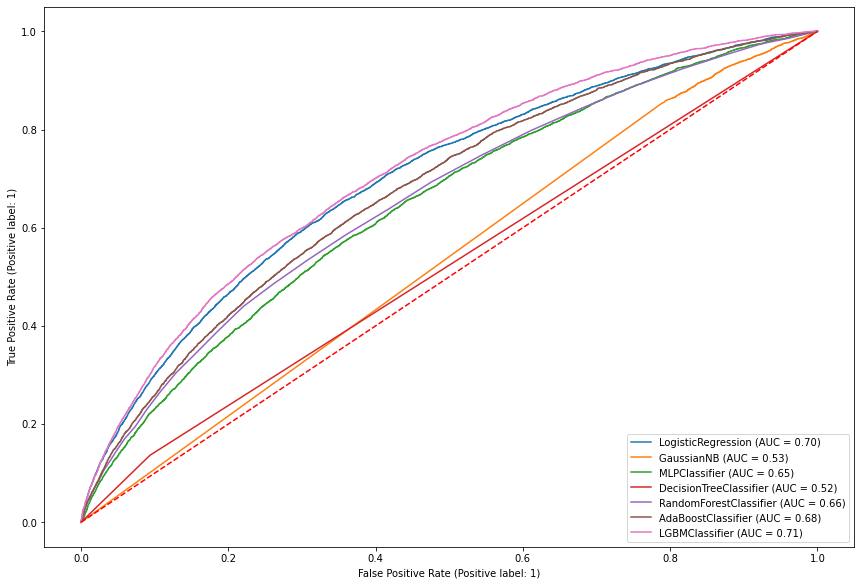

In [40]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots()
LR_disp = plot_roc_curve(LR, X_test, y_test,ax = ax)
gnb_disp = plot_roc_curve(gnb, X_test, y_test,ax = ax)
dnn_disp = plot_roc_curve(dnn, X_test, y_test,ax = ax)
clf_disp = plot_roc_curve(clf, X_test, y_test,ax = ax)
rfc_disp = plot_roc_curve(rfc, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(ada, X_test, y_test,ax= ax)
ada_disp = plot_roc_curve(gbm, X_test, y_test,ax= ax)

ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust( right=2, top = 2)
# LR_disp.figure_.suptitle("ROC curve comparison")
# ax.set_title("ROC curve comparison")
plt.show()

# 综合采样

In [51]:
train_smt, test_smt = split_train(data,0.2)
ex_test = test_smt.sample(frac=0.20, axis = 0)
train_smt_l = train_smt.iloc[ex_test.shape[0]:train_smt.shape[0], :]
train_app = pd.concat([train_smt_l, ex_test])

train_app = train_app.iloc[2004 : train_app.shape[0],:]

train_app_x = train_app.drop(['TARGET','SK_ID_CURR'],axis = 1)
train_app_y = train_app.loc[:,['TARGET']].values

test_app_x = test_smt.drop(['TARGET','SK_ID_CURR'],axis = 1)
test_app_y = test_smt['TARGET'].values


X_train = preprocessor.transform(train_app_x[features])
y_train = train_app_y
X_test = preprocessor.transform(test_app_x[features])
y_test = test_app_y

smt = SMOTETomek(random_state=42)
smt.fit(X_train, y_train)

SMOTETomek(random_state=42)

In [52]:
print('Original dataset shape %s' % Counter(train_app["TARGET"]))

X_train, y_train = smt.fit_resample(X_train, y_train)
test = y_train.reshape(y_train.shape[0],)

print('SMOTE + Tomek links dataset shape %s' % Counter(test))

Original dataset shape Counter({0: 224337, 1: 19668})
SMOTE + Tomek links dataset shape Counter({0: 224337, 1: 224337})


In [53]:
LR, gnb,dnn, clf, rfc,ada,gbm = model_process(X_train, y_train, X_test, y_test)

=============================逻辑回归================================
训练开始
训练结束
训练集精确度:{0.678}     测试集精确度:{0.670}    

predict_proba 训练集auc:{0.741}  训练集auc:{0.700}

classification_report:
              precision    recall  f1-score   support

           0       0.95      0.67      0.79     56484
           1       0.14      0.62      0.24      5018

    accuracy                           0.67     61502
   macro avg       0.55      0.65      0.51     61502
weighted avg       0.89      0.67      0.74     61502

LR 的KS:{0.3007}
=============================GaussianNB================================
训练开始
训练结束
训练集精确度:{0.544}     测试集精确度:{0.208}    

predict_proba 训练集auc:{0.562}  训练集auc:{0.532}

classification_report:
              precision    recall  f1-score   support

           0       0.94      0.15      0.25     56484
           1       0.09      0.90      0.16      5018

    accuracy                           0.21     61502
   macro avg       0.51      0.52      0.21     61502
weighted av

<Figure size 1296x576 with 0 Axes>

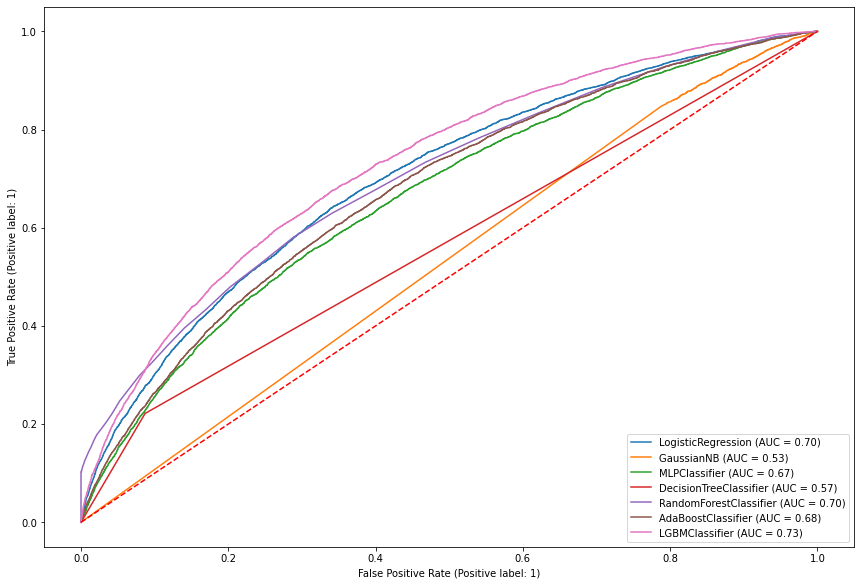

In [73]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots()
LR_disp = plot_roc_curve(LR, X_test, y_test,ax = ax)
gnb_disp = plot_roc_curve(gnb, X_test, y_test,ax = ax)
dnn_disp = plot_roc_curve(dnn, X_test, y_test,ax = ax)
clf_disp = plot_roc_curve(clf, X1_test, y1_test,ax = ax)
rfc_disp = plot_roc_curve(rfc, X1_test, y1_test,ax= ax)
ada_disp = plot_roc_curve(ada, X_test, y_test,ax= ax)
gbm_disp = plot_roc_curve(gbm, X_test, y_test,ax= ax)

ax.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.subplots_adjust( right=2, top = 2)
plt.show()

In [59]:
end = time.time()
print(end - start)

6097.0838141441345
